Team Name : Systumm


This notebook is used for Training the model which detects spills From given Images and this model us trained on 500 images taken from Instagram using Webscrapping

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Path to the "test" folder in your Google Drive
test = '/content/drive/MyDrive/test'

In [ ]:
!pip install jcopdl


  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-2.3.0-py2.py3-none-any.whl size=34049 sha256=3ab5fc2552af275385e16ff9a68b1c34dcdfbc75dc6760965d5acd52d017fc82
  Stored in directory: /root/.cache/pip/wheels/2f/35/6d/9e32b96b25d257d4655faac7801e3a900680dfc8ff35d24e95
Successfully built jcopdl


In [ ]:
!pip install --upgrade jcopdl==1.1.10

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=441cf248f7c95ec7382bd0f45c81f0bddd1056085b930352635c53efd59232a6
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl
  Attempting uninstall: jcopdl
    Found existing installation: jcopdl 2.3.0
    Uninstalling jcopdl-2.3.0:
      Successfully uninstalled jcopdl-2.3.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import jcopdl
from torch import nn, optim
from jcopdl.callback import Callback, set_config
# from jcopdl.callback import Callback , se

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
bs = 16
crop_size = 128

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale = (0.9, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/content/drive/MyDrive/Data for Project/train', transform=train_transform)
#train_set = datasets.ImageFolder('https://drive.google.com/drive/folders/1UDCC06w72us6dFazbCCDVUX9kbXWDQXC?usp=drive_link', transform=train_transform)

trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=1)
test_set = datasets.ImageFolder('/content/drive/MyDrive/Data for Project/test', transform=test_transform)
#test_set = datasets.ImageFolder('https://drive.google.com/drive/folders/10pHyYYy46OB547rPxC2aQw00wgcRqKsk?usp=drive_link', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [ ]:
feature, target = next (iter(trainloader))
feature.shape

torch.Size([16, 3, 128, 128])

In [ ]:
label2cat = train_set.classes
label2cat

['nospill', 'oilspill']

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            #Convolutional block 1
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            #Convolutional block 2
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            #Convolutional block 3
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            #Convolutional block 4
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            #Convolutional block 5
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            #Flattening
            nn.Flatten()
        )

        #Fully connected layer
        self.fc = nn.Sequential(
            #Linear 1024 -> 256
            nn.Linear(2048,256),
            nn.ReLU(),
            nn.Dropout(0.1),

            #Linear 256 -> 2
            nn.Linear(256, 2),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [ ]:
config = set_config({
    "batch_size" : bs,
    "crop_size": crop_size
})

# Training Preparation --> MCOC

In [ ]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir="model", early_stop_patience=  10)

# Training

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6942 | Test_cost  = 0.6956 | Train_score = 0.5025 | Test_score = 0.4490 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cebdaa3bbe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6932 | Test_cost  = 0.6954 | Train_score = 0.5025 | Test_score = 0.4490 |
==> EarlyStop patience =  1 | Best test_score: 0.4490


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6930 | Test_cost  = 0.6946 | Train_score = 0.5025 | Test_score = 0.4490 |
==> EarlyStop patience =  2 | Best test_score: 0.4490


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.6925 | Test_cost  = 0.6947 | Train_score = 0.5025 | Test_score = 0.4490 |
==> EarlyStop patience =  3 | Best test_score: 0.4490


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.6922 | Test_cost  = 0.6928 | Train_score = 0.5025 | Test_score = 0.4490 |
==> EarlyStop patience =  4 | Best test_score: 0.4490


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.6921 | Test_cost  = 0.6918 | Train_score = 0.5025 | Test_score = 0.5102 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.6894 | Test_cost  = 0.6871 | Train_score = 0.5939 | Test_score = 0.6735 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.6852 | Test_cost  = 0.6849 | Train_score = 0.6904 | Test_score = 0.6531 |
==> EarlyStop patience =  1 | Best test_score: 0.6735


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.6792 | Test_cost  = 0.6776 | Train_score = 0.7005 | Test_score = 0.6735 |
==> EarlyStop patience =  2 | Best test_score: 0.6735


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.6654 | Test_cost  = 0.6568 | Train_score = 0.6599 | Test_score = 0.6939 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.6452 | Test_cost  = 0.6366 | Train_score = 0.7107 | Test_score = 0.6939 |
==> EarlyStop patience =  1 | Best test_score: 0.6939


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.6419 | Test_cost  = 0.6609 | Train_score = 0.6142 | Test_score = 0.5510 |
==> EarlyStop patience =  2 | Best test_score: 0.6939


Exception ignored in: 

Train:   0%|          | 0/13 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7cebdaa3bbe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cebdaa3bbe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiproces

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.6148 | Test_cost  = 0.6168 | Train_score = 0.7005 | Test_score = 0.6327 |
==> EarlyStop patience =  3 | Best test_score: 0.6939


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.5803 | Test_cost  = 0.6247 | Train_score = 0.7208 | Test_score = 0.6735 |
==> EarlyStop patience =  4 | Best test_score: 0.6939


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.5592 | Test_cost  = 0.6213 | Train_score = 0.7107 | Test_score = 0.6531 |
==> EarlyStop patience =  5 | Best test_score: 0.6939


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.5439 | Test_cost  = 0.6445 | Train_score = 0.7563 | Test_score = 0.6122 |
==> EarlyStop patience =  6 | Best test_score: 0.6939


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.5307 | Test_cost  = 0.6408 | Train_score = 0.7157 | Test_score = 0.6735 |
==> EarlyStop patience =  7 | Best test_score: 0.6939


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.5525 | Test_cost  = 0.6294 | Train_score = 0.7208 | Test_score = 0.6735 |
==> EarlyStop patience =  8 | Best test_score: 0.6939


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.5199 | Test_cost  = 0.6321 | Train_score = 0.7563 | Test_score = 0.6735 |
==> EarlyStop patience =  9 | Best test_score: 0.6939


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.5234 | Test_cost  = 0.6555 | Train_score = 0.7310 | Test_score = 0.5714 |


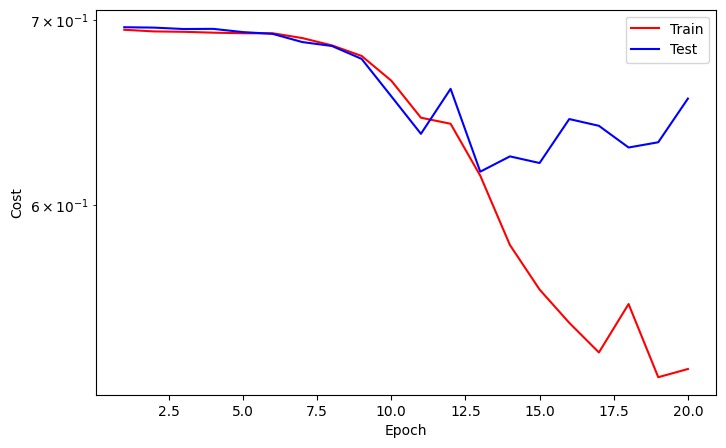

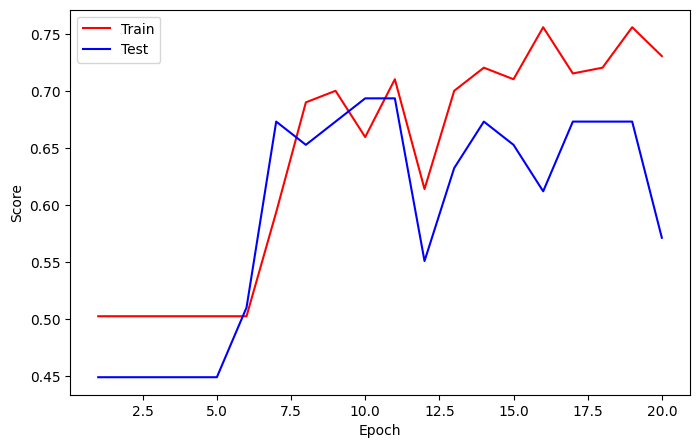

==> EarlyStop patience = 10 | Best test_score: 0.6939
==> Execute Early Stopping at epoch: 20 | Best test_score: 0.6939
==> Best model is saved at model


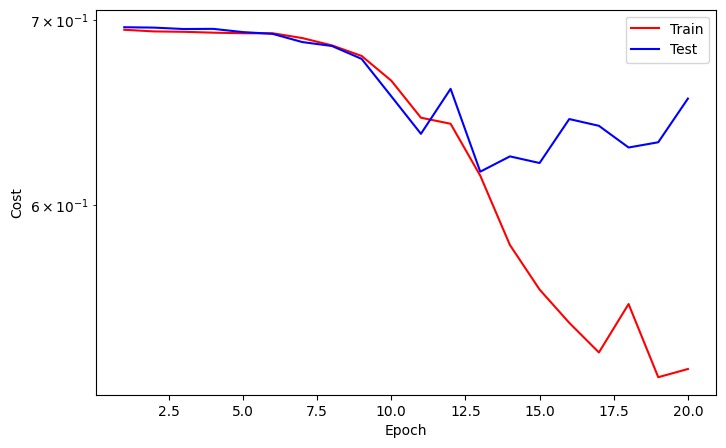

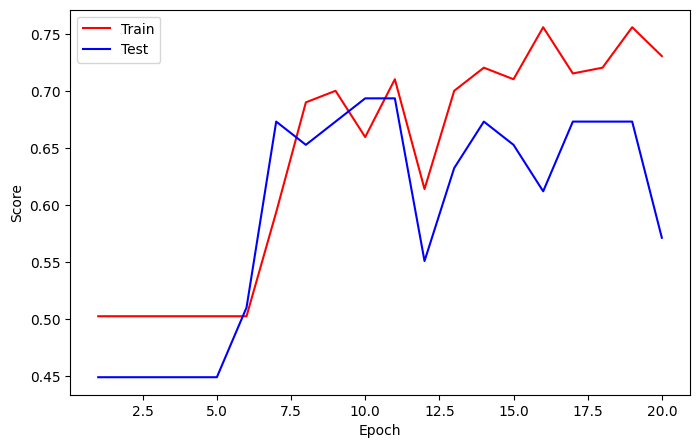

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model (feature)
    preds = output
preds

# Probability and classification

In [ ]:
np.exp(preds), preds.argmax(1)

In [ ]:
max(np.exp(preds[0]))

# Sanity check

In [ ]:
fig, axes = plt.subplots(4,4, figsize = (24,24))

for img, label, pred, ax in zip (feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color": 'r'} if label != pred.argmax(0) else {"color":'g'}
    label, pred, prob = label2cat [label.item()], label2cat[pred.argmax(0).item()], "{:.2f}".format(max(np.exp(pred)).item())
    ax.set_title(f"Label: {label} | Pred: {pred} | Prob: {prob}", fontdict= font)
    ax.axis("off")

In [ ]:
fig.savefig("oilspill.png")

In [ ]:
crop_size = 128
loader = transforms.Compose([
            transforms.Resize(70),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor()])

In [ ]:
from PIL import Image
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

In [ ]:
images = image_loader("oil spill.jpg")
images.shape

torch.Size([1, 3, 128, 128])

In [ ]:
with torch.no_grad():
    model.eval()
    output = model (images)
    print(f"there is %s with probability %s" %(label2cat[output.argmax(1).item()], "{:.2f}".format(max(np.exp(output)[0]))))

there is oilspill with probability 0.54


In [ ]:
# Save the entire model (including architecture and state_dict)
torch.save(model, 'oil spill.pth')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/spill.pth')